# Statisticsal Analysis of Temperature Data

# Modelling Daily Average Temperatures (DAT)
## Modelling Seasonality
We need to de-trend and remove seasonality:

1. statsmodels decompose function classical decomposition using moving averages
2. De-trend and model seasonal component as fourier series

## Modelling Temperature
For modelling temps we will look at using two different approaches

3. Time Series ARMA model
4. mean reverting Ornstein-Uhlenbeck process

## Modelling Temperature Volatility
We will also need to model temperature volatility

5. Fourier series to model the volatility of temperature
6. Parametric Regression - Polynomial
7. Local and Nonparametric Regression - Splines
8. piece-wise non-constant functions with each piece capturing volatility for each season

## Pricing Temperature Options

We can use the statistical analysis of historical temperature data and models to price options.

We will quickly examine:

9. Actuarial approach like historical 'burn' analyis
10. Alternative Black Scholes approach with OU dynamics
11. Monte Carlo - with Time Series model
12. Monte Carlo - with OU model

https://www.ncei.noaa.gov/access/search/data-search/local-climatological-data-v2?bbox=44.481,-95.906,39.669,-91.094&pageNum=1&startDate=2000-01-01T00:00:00&endDate=2024-01-01T23:59:59

Dataset Start to End:
- Weather Station 1: 1-Jan 2000 - 1-Jan 2024

Data available:
- Maximum Temperature
- Minimum Temperature

In [1]:
import os
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

In [44]:
df_weather = pd.read_csv('iowaweather.csv')
df_weather.tail()

<ipython-input-44-132f6babdf58>:1: DtypeWarning: Columns (62) have mixed types. Specify dtype option on import or set low_memory=False.
  df_weather = pd.read_csv('iowaweather.csv')


,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,REPORT_TYPE,SOURCE,HourlyAltimeterSetting,HourlyDewPointTemperature,...,BackupDirection,BackupDistance,BackupDistanceUnit,BackupElements,BackupElevation,BackupEquipment,BackupLatitude,BackupLongitude,BackupName,WindEquipmentChangeDate
12602,USW00014933,2006-12-31T20:55:00,41.5338,-93.653,291.7,"DES MOINES INTERNATIONAL AIRPORT, IA US",FM-16,343.0,1009.5,-4.0,...,N,1,mi,ALL ELEMENTS,950,"SRG, SNOWSTICK, SNOWBOARD",41.5414,-93.6556,FAA CONTRACT OBSERVER,10/20/2005
12603,USW00014933,2006-12-31T21:00:00,41.5338,-93.653,291.7,"DES MOINES INTERNATIONAL AIRPORT, IA US",FM-15,223.0,1009.5,-4.0,...,N,1,mi,ALL ELEMENTS,950,"SRG, SNOWSTICK, SNOWBOARD",41.5414,-93.6556,FAA CONTRACT OBSERVER,10/20/2005
12604,USW00014933,2006-12-31T21:54:00,41.5338,-93.653,291.7,"DES MOINES INTERNATIONAL AIRPORT, IA US",FM-15,343.0,1010.2,-3.3,...,N,1,mi,ALL ELEMENTS,950,"SRG, SNOWSTICK, SNOWBOARD",41.5414,-93.6556,FAA CONTRACT OBSERVER,10/20/2005
12605,USW00014933,2006-12-31T22:54:00,41.5338,-93.653,291.7,"DES MOINES INTERNATIONAL AIRPORT, IA US",FM-15,343.0,1010.8,-3.3,...,N,1,mi,ALL ELEMENTS,950,"SRG, SNOWSTICK, SNOWBOARD",41.5414,-93.6556,FAA CONTRACT OBSERVER,10/20/2005
12606,USW00014933,2006-12-31T23:54:00,41.5338,-93.653,291.7,"DES MOINES INTERNATIONAL AIRPORT, IA US",FM-15,343.0,1011.5,-2.8,...,N,1,mi,ALL ELEMENTS,950,"SRG, SNOWSTICK, SNOWBOARD",41.5414,-93.6556,FAA CONTRACT OBSERVER,10/20/2005


In [45]:
max_temp = pd.read_csv('maximum temp.csv')
min_temp = pd.read_csv('minimum temp.csv')
min_temp.tail()

,Product code,Bureau of Meteorology station number,Year,Month,Day,Minimum temperature (Degree C),Days of accumulation of minimum temperature,Quality
59043,IDCJAC0011,66062,2020,8,27,6.8,1.0,Y
59044,IDCJAC0011,66062,2020,8,28,10.4,1.0,Y
59045,IDCJAC0011,66062,2020,8,29,7.9,1.0,Y
59046,IDCJAC0011,66062,2020,8,30,8.9,1.0,Y
59047,IDCJAC0011,66062,2020,8,31,12.7,1.0,Y


## Check for missing data

In [4]:
max_temp.isnull().value_counts(),min_temp.isna().value_counts()

(Product code  Bureau of Meteorology station number  Year   Month  Day    Maximum temperature (Degree C)  Days of accumulation of maximum temperature  Quality
 False         False                                 False  False  False  False                           False                                        False      58759
                                                                          True                            True                                         True         150
                                                                          False                           True                                         False        135
                                                                          True                            False                                        True           2
                                                                          False                           False                                        True           1
 

In [5]:
# Are these the same days? If not will have to drop all rows (days) with at least value missing
count = 0 
for mx, mn in zip(np.where(max_temp.isnull())[0], np.where(min_temp.isnull())[0]):
    if mx != mn:
        count += 1

print('Number of Misaligned Null Values: ', count)

Number of Misaligned Null Values:  35


### Here's a breakdown of the code's functionality:

1. Initializing a Counter:

    count = 0: This line initializes a variable named count to 0, which will be used to track the number of specific occurrences as the code iterates.

2. Finding Null Indices:

    np.where(max_temp.isnull())[0] and np.where(min_temp.isnull())[0]: These expressions use NumPy's where function to find the indices (positions) of null values (missing data) within the arrays max_temp and min_temp, respectively. The [0] part extracts only the indices from the result.

3. Iterating and Counting:

    for mx, mn in zip(...): This line initiates a for loop that iterates through pairs of indices (mx for max_temp and mn for min_temp) obtained from the previous step. The zip function pairs corresponding elements from the two lists of indices.
if mx != mn:: This condition checks if the indices for null values in max_temp and min_temp at the current iteration are different.
If they are different (mx != mn), the code executes count += 1, incrementing the count variable.

### Overall Purpose:

The code is designed to count the number of instances where null values occur at different positions within the max_temp and min_temp arrays. It specifically focuses on cases where the missing data points are not aligned in both arrays.
It specifically targets cases where null values don't align in both arrays, providing insights into potential discrepancies in missing data patterns.

## Create cleaned max min temperature dataframe

In [6]:
def datetime(row):
    return dt.datetime(row.Year,row.Month,row.Day)

In [7]:
max_temp['Date'] = max_temp.apply(datetime,axis=1)
min_temp['Date'] = min_temp.apply(datetime,axis=1)
max_temp.set_index('Date', inplace=True)
min_temp.set_index('Date', inplace=True)
drop_cols = [0,1,2,3,4,6,7]
max_temp.drop(max_temp.columns[drop_cols],axis=1,inplace=True)
min_temp.drop(min_temp.columns[drop_cols],axis=1,inplace=True)
max_temp.rename(columns={'Maximum temperature (Degree C)':'Tmax'}, inplace=True)
min_temp.rename(columns={'Minimum temperature (Degree C)':'Tmin'}, inplace=True)

In [8]:
temps = max_temp.merge(min_temp,how='inner',left_on=['Date'],right_on=['Date'])

def avg_temp(row):
    return (row.Tmax+row.Tmin)/2

temps['T'] = temps.apply(avg_temp,axis=1) # calculates the average temperature for each row in the temps DataFrame and stores the results in a new column named 'T'

# drop na values here
temps = temps.dropna()
temps

,Tmax,Tmin,T
Date,,,
1859-01-01,24.4,14.5,19.45
1859-01-02,24.4,15.7,20.05
1859-01-03,24.2,15.3,19.75
1859-01-04,24.7,17.4,21.05
1859-01-05,24.6,16.9,20.75
...,...,...,...
2020-08-26,19.6,6.8,13.20
2020-08-27,22.2,6.8,14.50
2020-08-28,19.7,10.4,15.05


In [9]:
temps.describe()

,Tmax,Tmin,T
count,58889.000000,58889.000000,58889.000000
mean,21.745061,13.809998,17.777530
std,4.671522,4.442761,4.296441
min,7.700000,2.100000,6.400000
25%,18.200000,10.100000,14.200000
50%,21.600000,14.000000,17.900000
75%,24.900000,17.500000,21.100000
max,45.800000,27.600000,33.750000


## Indicate winter and summer periods

Australia:
1. Winter ~ May-Oct
2. Summer ~ Nov-Aor

In [10]:
temps_season = temps.copy(deep=True)
temps_season['month'] = temps_season.index.month
mask = (temps_season['month'] >= 5) & (temps_season['month'] <= 10)
temps_season['winter'] = np.where(mask,1,0)
temps_season['summer'] = np.where(temps_season['winter'] != 1,1,0) # creates a binary indicator for the 'summer' season based on the values in the 'winter' column.
temps_season

,Tmax,Tmin,T,month,winter,summer
Date,,,,,,
1859-01-01,24.4,14.5,19.45,1,0,1
1859-01-02,24.4,15.7,20.05,1,0,1
1859-01-03,24.2,15.3,19.75,1,0,1
1859-01-04,24.7,17.4,21.05,1,0,1
1859-01-05,24.6,16.9,20.75,1,0,1
...,...,...,...,...,...,...
2020-08-26,19.6,6.8,13.20,8,1,0
2020-08-27,22.2,6.8,14.50,8,1,0
2020-08-28,19.7,10.4,15.05,8,1,0


## Data Visualisation

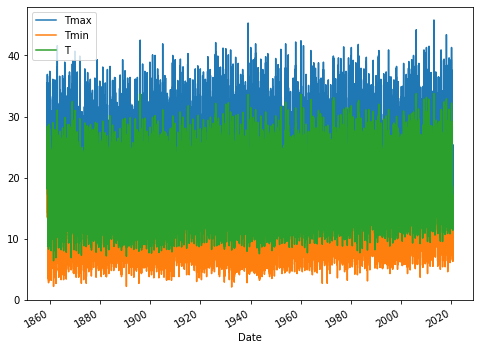

In [11]:
temps[:].plot(figsize=(8,6))
plt.show()

The expression temps[:] returns a copy of the entire temps array. Here's how it works:

1. temps: This is the name of the array you want to copy.

2. [:]: This is a slice that selects all elements from the array.

The colon (:) on its own indicates that you want to select all elements from the start to the end of the array.
In this case, it's equivalent to temps[0:len(temps)], which explicitly specifies the start and end indices.

##### Points to Note:

The [:] slice can be used with other Python data structures like lists and strings to select all elements.
Assigning a slice to a variable creates a copy of the selected elements, not a reference to the original data.

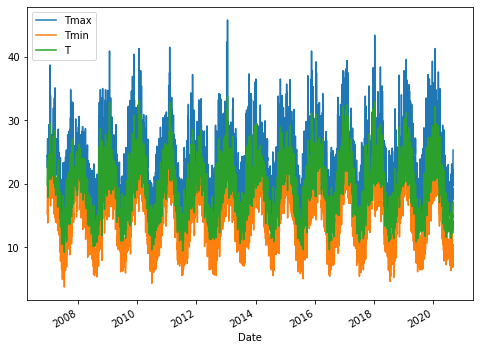

In [12]:
# last 12 year period
temps[-5000:].plot(figsize=(8,6)) #temps[-5000:]: This selects the last 5000 elements of the temps array using slicing
plt.show()

## Temperature distribution

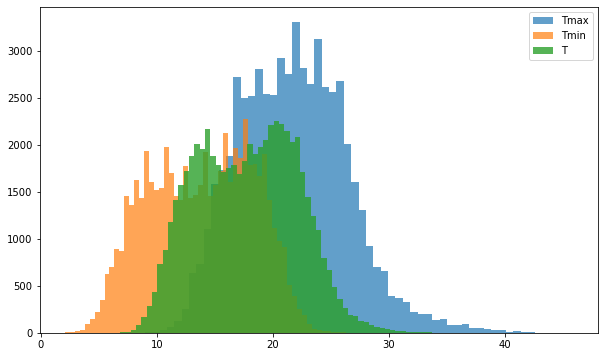

In [13]:
plt.figure(figsize=(10,6))
temps.Tmax.hist(bins=60, alpha=0.7, label='Tmax')
temps.Tmin.hist(bins=60, alpha=0.7, label='Tmin')
temps['T'].hist(bins=60, alpha=0.8, label='T')
plt.grid(False)
plt.legend()
plt.show()

## Bimodal Distribution

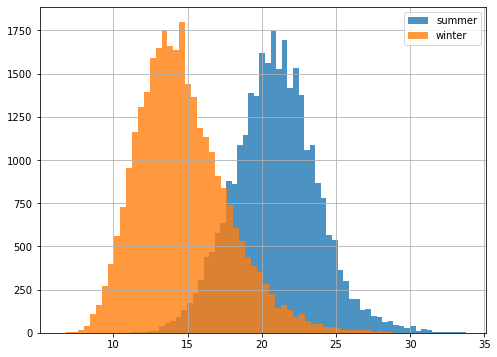

In [14]:
plt.figure(figsize=(8,6))
temps_season[temps_season['summer'] == 1]['T'].hist(bins=60, alpha=0.8, label='summer')
temps_season[temps_season['winter'] == 1]['T'].hist(bins=60, alpha=0.8, label='winter')
plt.legend()
plt.show()

## Temperature Records
Compile list of min and max records for each month on record.

In [15]:
# can be done for whatever season you'd like
date_list = temps.index.tolist()
mth_temps = pd.DataFrame(data=date_list, index=date_list).resample('MS')[0].agg([min, max])
mth_temps['month'] = mth_temps.index.month
def min_max_temps(row):
    stats = temps[(temps.index >= row['min']) & (temps.index <= row['max'])].agg([min, max])
    row['Tmax_max'] = stats.loc['max', 'Tmax']
    row['Tmax_min'] = stats.loc['min', 'Tmax']
    row['Tmin_max'] = stats.loc['max', 'Tmin']
    row['Tmin_min'] = stats.loc['min', 'Tmin']
    row['T_max'] = stats.loc['max', 'T']
    row['T_min'] = stats.loc['min', 'T']
    return row

mth_temps = mth_temps.apply(min_max_temps,axis=1)
mth_temps


,min,max,month,Tmax_max,Tmax_min,Tmin_max,Tmin_min,T_max,T_min
1859-01-01,1859-01-01,1859-01-31,1,36.9,20.6,19.9,14.5,28.40,18.10
1859-02-01,1859-02-01,1859-02-28,2,35.6,19.9,20.0,13.3,26.95,17.25
1859-03-01,1859-03-01,1859-03-31,3,30.4,18.8,18.9,13.3,23.55,17.10
1859-04-01,1859-04-01,1859-04-30,4,31.1,16.8,17.7,7.8,22.45,13.25
1859-05-01,1859-05-01,1859-05-31,5,28.6,13.9,16.7,4.6,22.65,9.25
...,...,...,...,...,...,...,...,...,...
2020-04-01,2020-04-01,2020-04-30,4,29.2,19.6,20.2,11.3,22.95,16.40
2020-05-01,2020-05-01,2020-05-31,5,28.5,15.6,17.2,7.8,22.10,12.55
2020-06-01,2020-06-01,2020-06-30,6,22.6,15.1,14.5,7.2,18.55,11.55
2020-07-01,2020-07-01,2020-07-31,7,23.0,15.0,13.6,7.1,17.05,12.50


## Temperature Extreme's on record

In [16]:
grouped_mths = mth_temps.groupby(mth_temps.month)[['Tmax_max', 'Tmax_min', 'Tmin_max', 'Tmin_min','T_max','T_min']].agg([min, max])
grouped_mths['months'] = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
grouped_mths = grouped_mths.set_index('months')
grouped_mths[[('Tmax_max', 'max'),('Tmin_min', 'min'),('Tmax_min', 'min'),('Tmin_max', 'max')]]

,Tmax_max,Tmin_min,Tmax_min,Tmin_max
,max,min,min,max
months,,,,
Jan,45.8,10.6,17.2,26.2
Feb,42.1,9.6,15.6,27.6
Mar,39.8,9.3,16.2,25.4
Apr,35.4,7.0,13.8,24.3
May,30.0,4.4,11.3,20.8
Jun,26.9,2.1,9.7,18.4
Jul,26.5,2.2,7.7,18.1
Aug,31.3,2.7,9.1,19.7


In [17]:
grouped_mths[[('T_max', 'max'),('T_max', 'min'),('T_min', 'max'),('T_min', 'min')]]

T_max         T_min       
          max    min    max    min
months                            
Jan     33.75  22.75  21.95  15.05
Feb     33.10  23.20  21.95  12.60
Mar     31.75  22.15  20.65  13.10
Apr     29.10  19.45  18.20  11.20
May     24.55  16.20  14.95   9.20
Jun     21.60  13.25  12.90   7.80
Jul     20.90  12.35  12.50   6.40
Aug     25.05  14.45  12.45   7.30
Sep     26.90  17.25  15.25   7.85
Oct     30.55  19.05  17.50   9.90
Nov     32.25  20.40  18.35  12.45
Dec     32.60  22.05  20.40  14.00

Code 1 is like searching for the maximum and minimum number of pages within each genre category.
Code 2 is like searching for the maximum and minimum number of pages for all books (assuming they were previously categorized by genre and then renamed to just "books").
- selects the maximum and minimum values of the renamed columns (T_max and T_min) for each month group.

# Decompose Time-Series Components
Time series decomposition is a technique that splits a time series into several components, each representing an underlying pattern category, trend, seasonality, and noise.

1. Trend: decreasing, constant, or increasing over time?
2. Seasonality: what is the periodic signal?
3. Noise: variability in the data that cannot be explained by the model

This is a naive decomposition - classical decomposition. More sophisticated methods should be preferred.

In [18]:
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order, AutoRegResults

In [19]:
temps.sort_index(inplace=True)
temps

,Tmax,Tmin,T
Date,,,
1859-01-01,24.4,14.5,19.45
1859-01-02,24.4,15.7,20.05
1859-01-03,24.2,15.3,19.75
1859-01-04,24.7,17.4,21.05
1859-01-05,24.6,16.9,20.75
...,...,...,...
2020-08-26,19.6,6.8,13.20
2020-08-27,22.2,6.8,14.50
2020-08-28,19.7,10.4,15.05


## Clear upward trend in temperature over time

<AxesSubplot:title={'center':'Rolling mean over annual periods'}, xlabel='Date'>

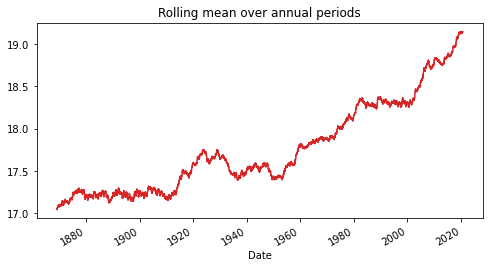

In [20]:
temps['T'].rolling(window = 365*10).mean().plot(figsize=(8,4), color="tab:red", title="Rolling mean over annual periods")

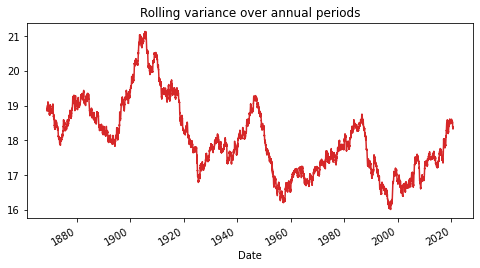

In [27]:
temps['T'].rolling(window = 365*10).var().plot(figsize=(8,4), color="tab:red", title="Rolling variance over annual periods")
plt.show()

## Use seasonal_decompose function

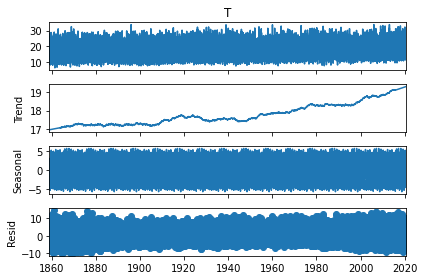

In [28]:
decompose_result = seasonal_decompose(temps['T'], model='additive', period=int(365*10), extrapolate_trend='freq')

trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

decompose_result.plot()
plt.show()

## Visualise 10 years
two-sided moving average is done in two parts; first being the first 5 years and the second being the last 5 years. In turn, there is no real moving average term calculated in those last periods.
This is one of the downsides to classical de-composition. We can extrapolate projected trajectory by setting the moving average to the frequency

(-15.0, 15.0)

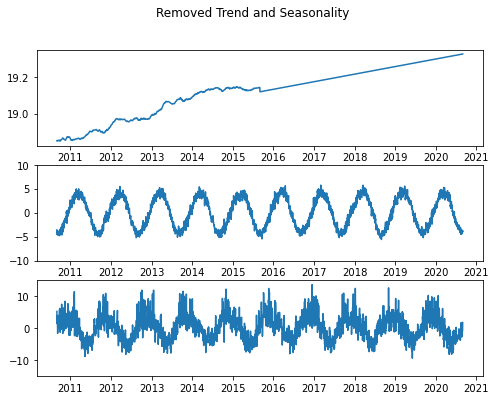

In [29]:
years_examine = 365*10
fig, axs = plt.subplots(3, figsize=(8,6))
fig.suptitle('Removed Trend and Seasonality')
axs[0].plot(trend[-years_examine:])
axs[1].plot(seasonal[-years_examine:])
axs[1].set_ylim([-10,10])
axs[2].plot(residual[-years_examine:])
axs[2].set_ylim([-15,15])

## Check residual distribution

<AxesSubplot:>

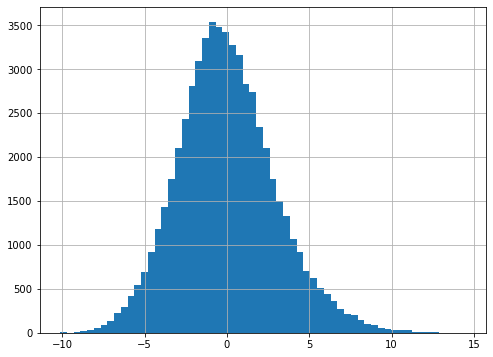

In [30]:
residual.hist(bins=60, figsize=(8,6))

## Testing for Stationarity with Dicky-Fuller
Below we'll test the stationarity of our time-series with this functionality and try to interpret its results to better understand it.

Unit Root Test, null hypothesis is that unit root exists.

In probability theory and statistics, a unit root is a feature of some stochastic processes (such as random walks) that can cause problems in statistical inference involving time series models. A linear stochastic process has a unit root if 1 is a root of the process's characteristic equation.

In [33]:
dftest = adfuller(residual, autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -20.410866551666725
2. P-Value :  0.0
3. Num Of Lags :  60
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 58828
5. Critical Values :
	 1% :  -3.430461164502673
	 5% :  -2.861589132589653
	 10% :  -2.566796151624216


## Analysis of Serial Correlations
Below we are also plotting auto-correlation plot for time-series data as well. This plot helps us understand whether present values of time-series are positively correlated, negatively correlated or not related at all with past values.

statsmodels library provides ready to use method plot_acf as a part of module statsmodels.graphics.tsaplots

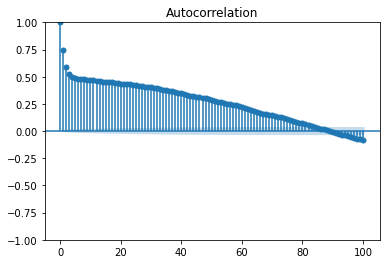

In [34]:
plot_acf(residual, lags=100)
plt.show()

Above we can see significant serial correlation. Since the auto-correlation funtion does not seem to vanish after a finite number of lags, we do not try and fit a moving average model.

### Determine AR order by use of PACF & AIC Criterion
PACF is a partial auto-correlation function. Basically instead of finding correlations of present values with lags like ACF, it finds correlation of the residuals.

These residuals remain after removing the effects which are already explained by the earlier lag(s) with the next lag value. i.e. We remove already found variations before we find the next correlation.Above we can see significant serial correlation. Since the auto-correlation funtion does not seem to vanish after a finite number of lags, we do not try and fit a moving average model.

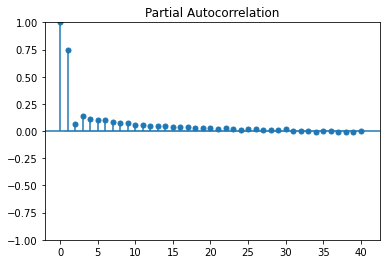

In [35]:
plot_pacf(residual, lags=40)
plt.show()

### Akaike Information Criterion (AIC)
AIC is a single number score that can be used to determine which of multiple models is most likely to be the best model for a given dataset. 
AIC works by evaluating the model’s fit on the training data, and adding a penalty term for the complexity of the model.

The desired result is to find the lowest possible AIC, which indicates the best balance of model fit with generalizability. This serves the eventual goal of maximizing fit on out-of-sample data.

In [39]:
residuals = residual.copy(deep=True)
residuals.index = pd.DatetimeIndex(residuals.index).to_period('D')

C:\Users\cozyc\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:2108: FutureWarning: old_names will be removed after the 0.14 release. You should stop setting this parameter and use the new names.
  full_mod = AutoReg(
C:\Users\cozyc\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:2185: FutureWarning: old_names will be removed after the 0.14 release. You should stop setting this parameter and use the new names.
  mod = AutoReg(


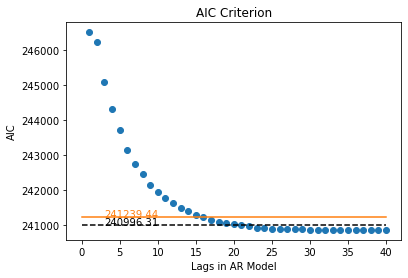

In [40]:
mod = ar_select_order(residuals, maxlag=40, ic='aic', old_names=True)

aic = []
for key, val in mod.aic.items():
    if key != 0:
        aic.append((key[-1], val))

aic.sort()
x,y = [x for x,y in aic],[y for x,y in aic]

plt.scatter(x, y)
plt.plot([0,40],[y[15],y[15]], 'tab:orange')
plt.text(3,y[15]+0.002, '{0}'.format(round(y[15],3)),color='tab:orange')
plt.plot([0,40],[y[20],y[20]], 'k--')
plt.text(3,y[20]-0.004, '{0}'.format(round(y[20],3)))
plt.title("AIC Criterion")
plt.xlabel("Lags in AR Model")
plt.ylabel("AIC")
plt.show()

### Fitting a AR with lags=15
Interpreting the results with statsmodels .summary()


In [41]:
model = AutoReg(residuals, lags=15, old_names=True,trend='n')
model_fit  = model.fit()
coef = model_fit.params
res = model_fit.resid
res.index = res.index.to_timestamp()
print(model_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:                  resid   No. Observations:                58889
Model:                    AutoReg(15)   Log Likelihood             -120691.441
Method:               Conditional MLE   S.D. of innovations              1.880
Date:                Thu, 22 Feb 2024   AIC                         241414.882
Time:                        18:59:38   BIC                         241558.612
Sample:                    01-16-1859   HQIC                        241459.565
                         - 08-30-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
resid.L1       0.6156      0.004    149.495      0.000       0.608       0.624
resid.L2      -0.0520      0.005    -10.749      0.000      -0.061      -0.043
resid.L3       0.0367      0.005      7.585      0.0

<ipython-input-41-bd8c998a6800>:1: FutureWarning: old_names will be removed after the 0.14 release. You should stop setting this parameter and use the new names.
  model = AutoReg(residuals, lags=15, old_names=True,trend='n')


Null hypothesis: there is no relationship with autoregressive term. i.e. coefficient = 0 -> P>\|z|

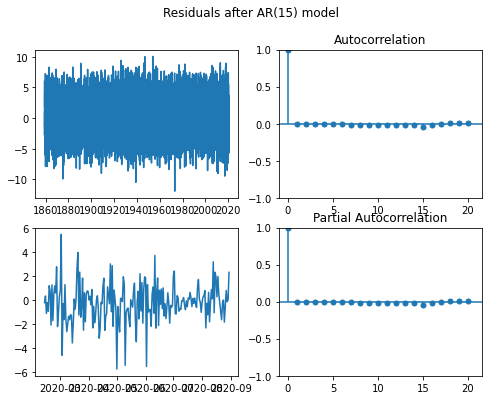

In [42]:
fig, axs = plt.subplots(2,2, figsize=(8,6))
fig.suptitle('Residuals after AR(15) model')
axs[0,0].plot(res)
axs[1,0].plot(res[-200:])
plot_acf(res, lags=20, ax=axs[0,1])
plot_pacf(res, lags=20, ax=axs[1,1])
plt.show()

The auto-correlation function of the raw residuals of the AR(15) model fitted to the remainder component of the daily temperature in Sydney, looks like white noise now! The serial correlation in the data appears to have been captured by the AR(15) model.

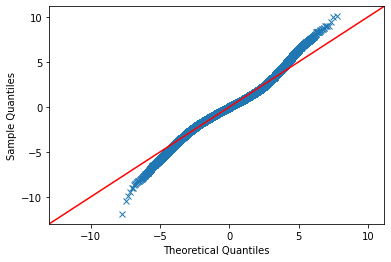

In [43]:
from scipy.stats import norm
qqplot(res, marker='x', dist=norm, loc=0, scale=np.std(res), line='45')
plt.show()